SWAN study: https://www.swanstudy.org

Datasets source: https://www.icpsr.umich.edu/web/ICPSR/series/00253

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
datasets = [
  Path("data/baseline-1996-1997/DS0001/28762-0001-Data.tsv"),
  Path("data/visit1-1997-1999/DS0001/29221-0001-Data.tsv"),
  Path("data/visit2-1998-2000/DS0001/29401-0001-Data.tsv"),
  Path("data/visit3-1999-2001/DS0001/29701-0001-Data.tsv"),
  Path("data/visit4-2000-2002/DS0001/30142-0001-Data.tsv"),
  Path("data/visit5-2001-2003/DS0001/30501-0001-Data.tsv"),
  Path("data/visit6-2002-2004/DS0001/31181-0001-Data.tsv"),
  Path("data/visit7-2003-2005/DS0001/31901-0001-Data.tsv"),
  Path("data/visit8-2004-2006/DS0001/32122-0001-Data.tsv"),
  Path("data/visit9-2005-2007/DS0001/32721-0001-Data.tsv"),
  Path("data/visit10-2006-2008/DS0001/32961-0001-Data.tsv")
]

dfs = [pd.read_csv(path, delimiter='\t', na_values=[' '], low_memory=False, ) for path in datasets]
# Each dataset is going to have columns like `FSH1`, `STATUS1` for visit 1.
# In order to plot data from all visits together, we want to combine all those columns
# For this, we create a list of DataFrames where those columns have been renamed
# without the number label at the end (`FSH1` -> `FSH`).
# This allows us to directly concatenate them at the end.
normalized = []
for i, full in enumerate(dfs):
  columns = full.columns
  renaming: dict[str, str] = {}
  for col in full.columns:
    num = str(i)
    if col.endswith(num):
      # Careful, num can be equal to 10, which is 2 characters
      new_name = col[:-len(num)]
      renaming[col] = new_name
  full = full.rename(renaming, axis=1)
  normalized.append(full)

full = pd.concat(dfs)
normalized = pd.concat(normalized)
# We can see the impact of combining columns across datasets on the shape
full.shape, normalized.shape

((28789, 9029), (28789, 2102))

In [34]:
# Make the STATUS column categorical
normalized["STATUS"] = normalized["STATUS"].astype("category")

# We have 7 samples with very high FSH. They are going to skew the Y axis,
# so we'll remove them before creating our plots in the next step.
len(normalized[normalized["FSH"] > 400])

7

percentage: 0.2563969571230982


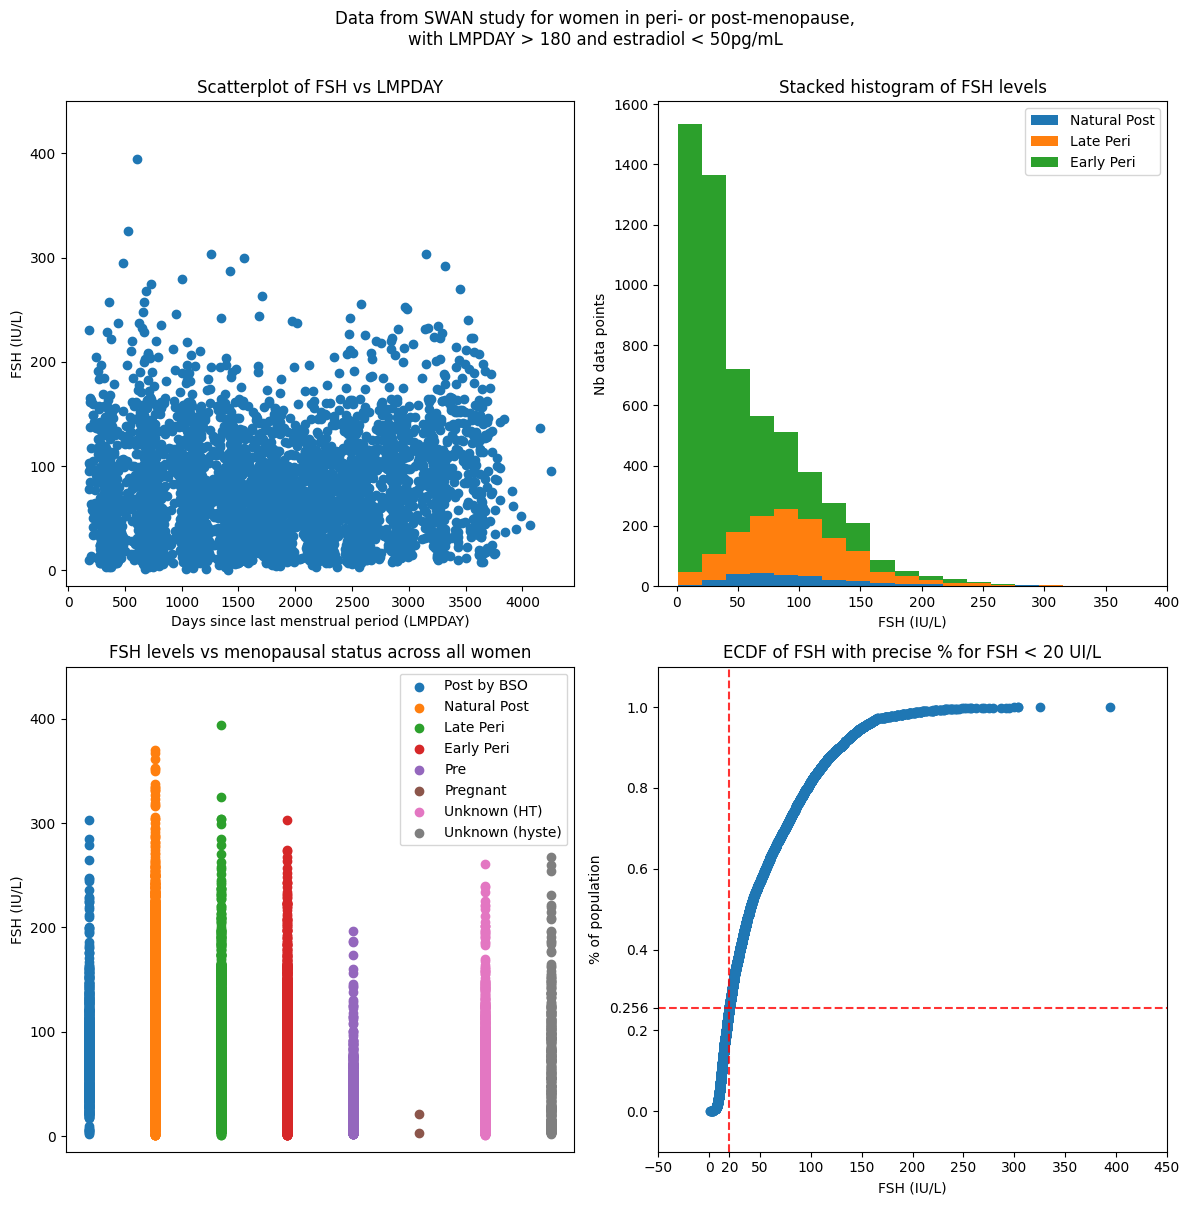

In [52]:
# This is the main thing of interest: plots of FSH vs other major variables
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12), tight_layout=True)

fig.suptitle("Data from SWAN study for women in peri- or post-menopause,\nwith LMPDAY > 180 and estradiol < 50pg/mL", y=1)

shared_ylim = (-15, 450)

ax1.set_ylim(shared_ylim)
ax3.set_ylim(shared_ylim)

# Filter out very high FSH levels to keep a reasonable Y axis
# data = normalized[normalized["FSH"] < 400]
data = normalized

# Filter for women in peri- or post-menopause
data = data[(data["STATUS"] == 2) | (data["STATUS"] == 3) | (data["STATUS"] == 4)]

# Our specific case: LMPDAY > 180 and low estradiol (<50)
data = data[(data["LMPDAY"] > 180) & (data["E2AVE"] < 50)]

# === Plot 1 ===
# Looking for a general trend in FSH vs LMPDAY, so not limiting ourselves to our case study
ax1.scatter(data["LMPDAY"], data["FSH"])
ax1.set_xlabel("Days since last menstrual period (LMPDAY)")
ax1.set_ylabel("FSH (IU/L)")
ax1.set_title("Scatterplot of FSH vs LMPDAY")

# === Plot 2 ===
status_labels = [
  (2, "Natural Post"),
  (3, "Late Peri"),
  (4, "Early Peri"),
]
chart_labels = []
chart_data = []

for (status, label) in status_labels:
  mask = data["STATUS"] == status
  chart_labels.append(label)
  chart_data.append(data[mask]["FSH"])

ax2.hist(chart_data, bins=20, stacked=True, label=chart_labels)

ax2.legend()
ax2.set_title("Stacked histogram of FSH levels")
ax2.set_xlim(-15, 400)
ax2.set_xlabel("FSH (IU/L)")
ax2.set_ylabel("Nb data points")

# === Plot 3 ===

# Remove the 7 outlier points with FSH above 400
plot3_data = normalized[normalized["FSH"] < 400]
fsh = plot3_data["FSH"]
status = plot3_data["STATUS"]
status_labels = [
  (1, "Post by BSO"),
  (2, "Natural Post"),
  (3, "Late Peri"),
  (4, "Early Peri"),
  (5, "Pre"),
  (6, "Pregnant"),
  (7, "Unknown (HT)"),
  (8, "Unknown (hyste)")
]
for (num, label) in status_labels:
  ax3.scatter(status[status == num], fsh[status == num], label=label)

ax3.legend()

ax3.set_xticks([])
ax3.set_title("FSH levels vs menopausal status across all women")
ax3.set_ylabel("FSH (IU/L)")

# === Plot 4 ===
# ECDF plot of FSH levels for women in late peri- or natural post-menopause with LMPDAY > 180
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

x,y = ecdf(data["FSH"])
# Compute the percentage of data points below 20 UI/L of FSH, which corresponds
# to the FSH threshold often used to determine menopause onset
threshold = 20
percentage = np.mean(x < threshold)
print("percentage:", percentage)


ax4.scatter(x, y)
# Add vertical and horizontal lines
ax4.axvline(threshold, linestyle="dashed", color="red", alpha=0.8)
ax4.axhline(percentage, linestyle="dashed", color="red", alpha=0.8)
# Add labels for the lines
xticks = ax4.get_xticks()
xticklabels = ax4.get_xticklabels()
ax4.set_xticks(np.append(xticks, threshold))
ax4.set_xticklabels(np.append(xticklabels, threshold))

yticks = ax4.get_yticks()
yticklabels = ax4.get_yticklabels()
ylabel = np.round(percentage, 3)
ax4.set_yticks(np.append(yticks, ylabel))
ax4.set_yticklabels(np.append(yticklabels, ylabel))

ax4.set_xlabel("FSH (IU/L)")
ax4.set_ylabel(r"% of population")
ax4.set_title(r"ECDF of FSH with precise % for FSH < 20 UI/L")
ax4.set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

<BarContainer object of 15 artists>

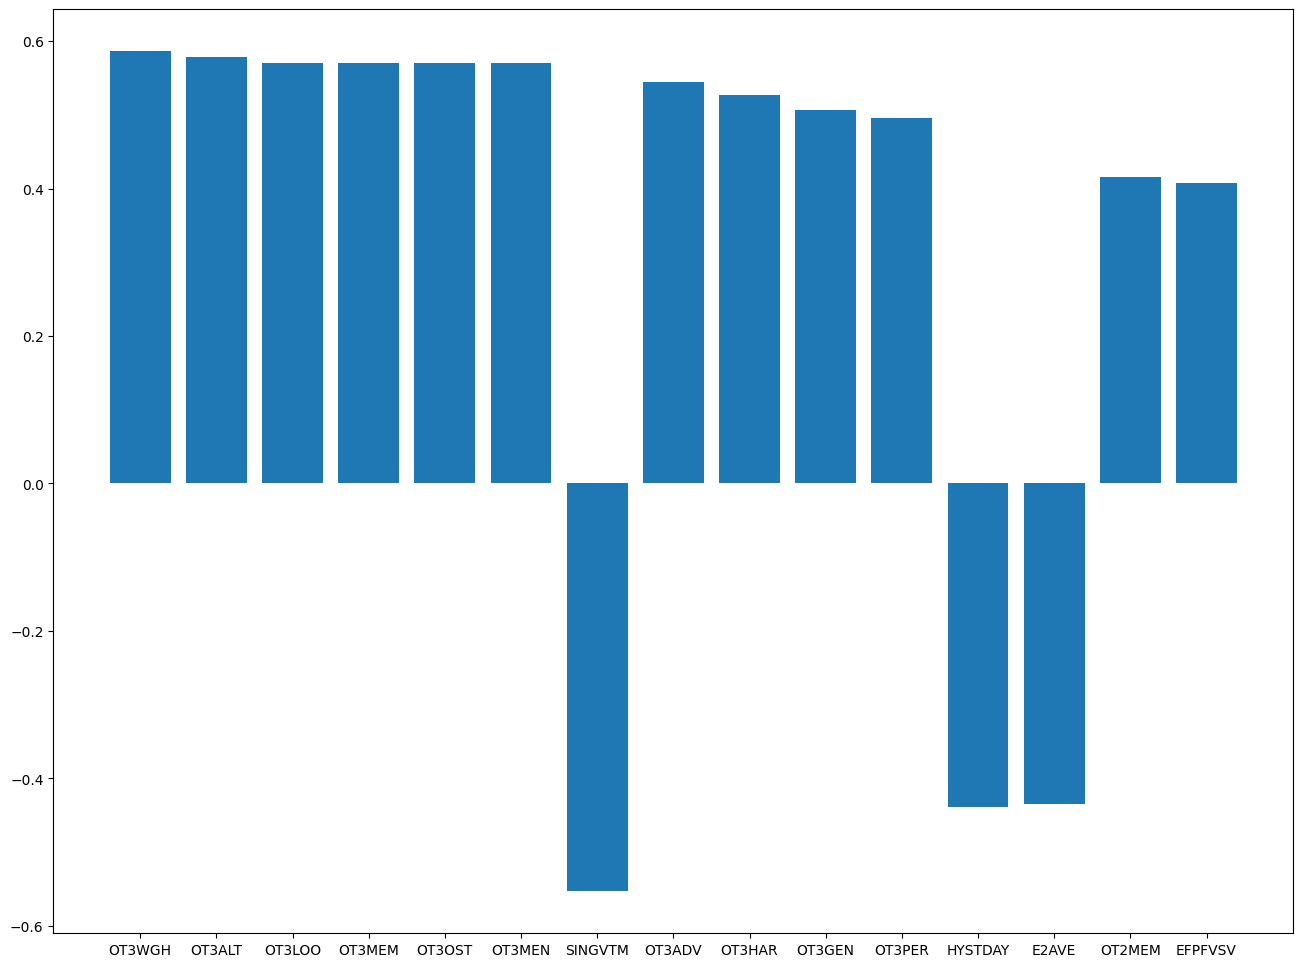

In [260]:
# 5th plot: histogram of strongest correlations with FSH,
# for women in late peri or natural post and LMPDAY > 180
# Not included above because it needs more refining: some of
# the numeric columns are actually categorical columns,
# which may skew the correlation calculation

corr = data.corr(numeric_only=True)
# Take the absolute value of the correlations
abs_corr = corr.abs()

# Select the correlations with the target column
corr_y = corr['FSH'].drop("FSH")
abs_corr_y = abs_corr['FSH'].drop("FSH")
corr_df = pd.DataFrame({"corr": corr_y, "abs_corr": abs_corr_y})

corr_df.sort_values(by="abs_corr", inplace=True, ascending=False)
corr_df = corr_df.head(15)
sorted_corr = corr_df["corr"]

plt.figure(figsize=(16, 12))
plt.bar(sorted_corr.index, sorted_corr.values)


In [261]:
# A rather unsuccessful attempt at training a model to predict FSH levels,
# to then rank the input features according to their importance.

import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split

df = normalized.copy()

# Only keep rows for which we have a FSH value
df = df[pd.notna(df["FSH"])]

# Drop all string or mixed columns (turning them to categorical features would require more careful work)
string_columns = df.select_dtypes(include=["object", "string"]).columns
df = df.drop(columns=string_columns)

X = df.drop(columns=["FSH"])
y = df["FSH"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the decision tree regression model
model = HistGradientBoostingRegressor(
    loss="absolute_error",
    min_samples_leaf=2, 
    early_stopping=True,
    max_iter=1000,
    # categorical_features=categorical_features
)

# Train the model on the training data
model.fit(X_train, y_train)

# Evaluate the model on the test data
score = model.score(X_test, y_test)
print(f"Test score: {score:.2f}")

In [ ]:
from sklearn.inspection import permutation_importance

# Get the feature importances
rankings = permutation_importance(model, X, y, n_jobs=-1)


/Users/erwin/Code/swan-study/.venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [ ]:
indices = (-rankings['importances_mean']).argsort()
# Print the feature ranking
print("Feature ranking:")
for i, feature in enumerate(X.columns[indices]):
    print(f"{i+1}. {feature} ({rankings['importances_mean'][indices[i]]})")


Feature ranking:
1. E2AVE (0.35678123422026714)
2. STATUS (0.10814235202400457)
3. STRTPER (0.09497630698797017)
4. WAIST (0.05735592899936326)
5. AGE (0.016844723632278513)
6. BLD3MON (0.016228150499545513)
7. RACE (0.014129963094324216)
8. BMI (0.012371692929308642)
9. SHBG (0.01193607246295898)
10. HOTFLAS (0.011673040628467458)
11. HDLRESU (0.010252982412750477)
12. DESCPER (0.008499464555829927)
13. HEIGHT (0.008437351917283564)
14. CYCDAY (0.007388079900257649)
15. WEIGHT (0.006694339786597547)
16. CRPRESU (0.005978511176713952)
17. SPEDAY (0.004816281222179586)
18. CONDRAW (0.0046948899724422065)
19. LMPDAY (0.003714311496647449)
20. CHOLRES (0.003644171714990585)
21. LENGCYL (0.003642667524379517)
22. HPBMDT (0.0036178438469328)
23. SPBMDT (0.003608559943928591)
24. T (0.003458617789985419)
25. BCPTWI1 (0.003338296564781351)
26. PBFBIA (0.0032309385984588433)
27. SWANID (0.002578366522360054)
28. CONDFRZ (0.002560835078672352)
29. DHAS (0.002341041584335102)
30. COMBTW1 (0.0021